## Initialize
#### Some parameters are initialized in module "params", file paths in "paths".

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy import signal
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms

h.dt = params.DT  # time step
h.steps_per_ms = 1/h.dt
h.tstop = params.TSTOP  # simulation stop time

## Setup smiulation parameters

#### Create cell

In [2]:
# Load biophysical parameters from json file
filepath = os.path.join(paths.RESOURCES_ROOT, 'biophys_parameters/ReducedOrderL5.json')
with open(filepath) as f:
    biophys_param = json.load(f)

for genome in biophys_param['genome']:
    if genome['value'] != "": genome['value'] = float(genome['value'])

geometry = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')  # load geometry file

cell = ReducedOrderL5Cell(geometry=geometry, full_biophys=biophys_param)  # create a cell object

#### Create synaptic input

In [3]:
gmax = 0.013  # synapse maximum conductance (uS)
stim = h.NetStim()
stim.number = 1  # only one event
stim.start = 2.0  # delay

cell.add_synapse(stim, sec_index=0, gmax=gmax)  # add an Exp2Syn synapse

#### Add ECP module

In [4]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# array of electrodes coordinates
print(params.ELECTRODE_POSITION)
print(params.ELECTRODE_POSITION.shape)

[[   -8. -1910.     0.]
 [   24. -1910.     0.]
 [  -24. -1890.     0.]
 ...
 [   24.  1890.     0.]
 [  -24.  1910.     0.]
 [    8.  1910.     0.]]
(384, 3)


## Run simulation

In [5]:
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)  # record time points
h.run()

0.0

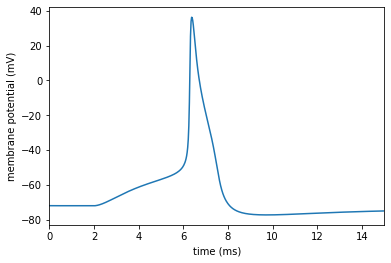

In [6]:
%matplotlib inline

t = t_vec.as_numpy().copy()
v = cell.v()

# plot membrane voltage
plt.figure()
plt.plot(t, v)
plt.ylabel('membrane potential (mV)');
plt.xlabel('time (ms)')
plt.xlim(t[[0, -1]])
plt.show()

## Set cell position and plot local field potential (LFP)

#### Position parameters (x, y, z, alpha, h, phi)
Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

#### You can change the position parameters and rerun codes below to see a change in LFP.

In [7]:
loc_param = [0., 0., 80., 0., 1., 0.]  # Position parameters

# get lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV
print(lfp.shape)  # time (ms) x channels (electrodes)

(601, 384)


#### Plot morphology and electrodes in 3D view

<IPython.core.display.Javascript object>


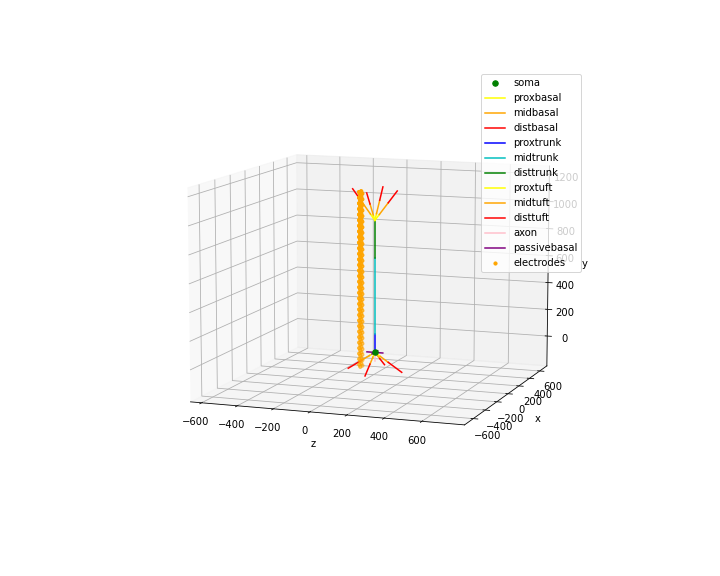

In [8]:
%matplotlib notebook

_ = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=10, azim=-70, figsize=(10,8),
                    clr = ['g',       #soma
                           'yellow',  #proxbasal
                           'orange',  #midbasal
                           'red',     #distbasal
                           'b',  #proxtrunk
                           'c',    #midtrunk
                           'g',   #disttrunk
                           'yellow',  #proxtuft
                           'orange',  #midtuft
                           'red',     #disttuft
                           'pink',       #axon
                           'purple']   #passivebasal
                   )

#### Plot raw LFP

In [9]:
x_dist = np.unique(elec_pos[:, 0])  # unique x coordinates of electrode array (columns)
print(x_dist)

ix = 1  # select a column
y_window = [-1000, 1000]  # select range of y coordinate for plotting

[-24.  -8.   8.  24.]


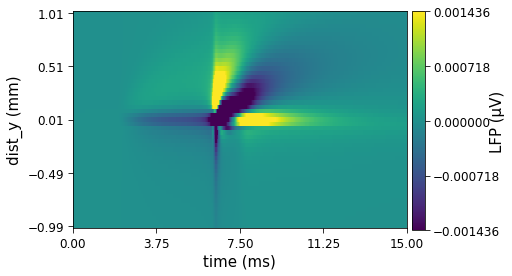

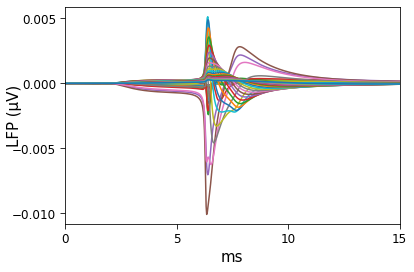

In [10]:
%matplotlib inline

fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

max_idx = np.argmax(np.amax(np.abs(lfp), axis=0))  # find the electrode that records maximum magnitude
ylim = elec_pos[max_idx, 1] + np.array(y_window)  # find range of y coordinate
e_idx = (elec_pos[:, 0]==x_dist[ix]) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # find indices of electrodes

# plot lfp along y-axis
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=15, labelpad=-10, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto')

_ = plot_lfp_traces(t, lfp[:, e_idx],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins)

plt.show()

#### Filter LFP and plot

In [11]:
filter_parameters = {'N': params.BUTTERWORTH_ORDER,
                     'Wn': params.FILTER_CRITICAL_FREQUENCY,
                     'btype': params.BANDFILTER_TYPE,
                     'fs': params.FILTER_SAMPLING_RATE}
print(filter_parameters)

filt_b, filt_a = signal.butter(**filter_parameters)
# help(signal.butter)  # see documentation of Butterworth  filter

{'N': 2, 'Wn': 100.0, 'btype': 'hp', 'fs': 40000.0}


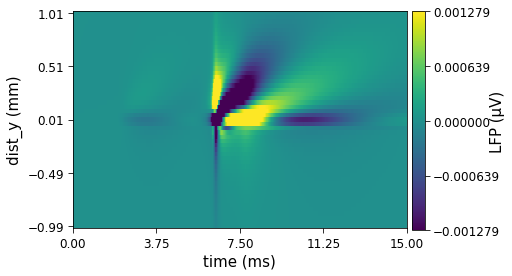

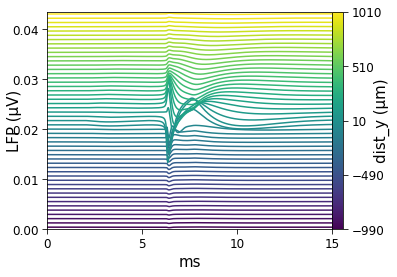

In [12]:
filtered_lfp = signal.lfilter(filt_b, filt_a, lfp, axis=0) # filter along time axis

max_idx = np.argmax(np.amax(np.abs(filtered_lfp), axis=0))  # find the electrode that records maximum magnitude
ylim = elec_pos[max_idx, 1] + np.array(y_window)  # find range of y coordinate
e_idx = (elec_pos[:, 0]==x_dist[ix]) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # find indices of electrodes

# plot lfp along y-axis
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=filtered_lfp[:, e_idx],
                     fontsize=15, labelpad=-10, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto')

_ = plot_lfp_traces(t, filtered_lfp[:, e_idx], electrodes=elec_pos[e_idx],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins)

plt.show()